<a href="https://colab.research.google.com/github/diogosantanaime/rec_proc/blob/main/run_flair_wikineural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 43.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 123.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 77.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 87.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.9 MB/s eta 0:00:

In [2]:
import os
import requests
import matplotlib.pyplot as plt
import random

from flair.datasets import ColumnCorpus
from flair.data import Corpus
from flair.embeddings import WordEmbeddings, StackedEmbeddings, TokenEmbeddings, FlairEmbeddings
from typing import List
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from flair.optim import SGDW

In [3]:
# URL base do diretório no GitHub
base_url = 'https://github.com/Babelscape/wikineural/raw/master/data/wikineural/en'

# Pasta de destino para salvar os arquivos
destination_folder = '.'

# Lista de arquivos para download
file_list = [
    'train.conllu',
    'test.conllu',
    'val.conllu'
]

# Cria a pasta de destino, se não existir
os.makedirs(destination_folder, exist_ok=True)

# Faz o download dos arquivos
for file_name in file_list:
    url = f'{base_url}/{file_name}'
    response = requests.get(url, allow_redirects=True)
    file_path = os.path.join(destination_folder, file_name)
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print(f'{file_name} baixado com sucesso.')

# Define os caminhos dos arquivos no formato local
train_file = os.path.join(destination_folder, 'train.conllu')
test_file = os.path.join(destination_folder, 'test.conllu')
dev_file = os.path.join(destination_folder, 'val.conllu')

train.conllu baixado com sucesso.
test.conllu baixado com sucesso.
val.conllu baixado com sucesso.


In [4]:
# Define um dicionário de mapeamento das colunas do corpus
columns = {0 : 'id', 1 : 'text', 2 : 'label'}

# Define o caminho para a pasta de dados do corpus
data_folder = '.'

# Cria um objeto Corpus usando a classe ColumnCorpus
# Passa o caminho da pasta de dados, o dicionário de colunas e os arquivos de treinamento, teste e desenvolvimento
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file = 'train.conllu',
                              test_file = 'test.conllu',
                              dev_file = 'val.conllu')

2023-05-31 17:27:51,358 Reading data from .
2023-05-31 17:27:51,360 Train: train.conllu
2023-05-31 17:27:51,363 Dev: val.conllu
2023-05-31 17:27:51,365 Test: test.conllu


In [5]:
# Imprime o número de sentenças no conjunto de treinamento
print("Número de sentenças de treinamento:", len(corpus.train))

# Imprime o número de sentenças no conjunto de teste
print("Número de sentenças de teste:", len(corpus.test))

# Imprime o número de sentenças no conjunto de desenvolvimento
print("Número de sentenças de desenvolvimento:", len(corpus.dev))

Número de sentenças de treinamento: 92720
Número de sentenças de teste: 11597
Número de sentenças de desenvolvimento: 11590


In [6]:
# Define o limite de sentenças para cada conjunto
train_limit = 14000
test_limit = 3500
dev_limit = 3500

# Lista para armazenar as sentenças selecionadas
train_sentences = []
test_sentences = []
dev_sentences = []

# Contadores para o número de sentenças em cada conjunto
train_count = 0
test_count = 0
dev_count = 0

# Percorre as sentenças do conjunto de treinamento
for sentence in corpus.train:
    # Verifica se o rótulo não é "<unk>"
    if sentence.labels[0].value != '<unk>':
        # Adiciona a sentença ao conjunto de treinamento
        train_sentences.append(sentence)
        train_count += 1

        # Verifica se atingiu o limite de sentenças do conjunto de treinamento
        if train_count == train_limit:
            break

# Percorre as sentenças do conjunto de teste
for sentence in corpus.test:
    # Verifica se o rótulo não é "<unk>"
    if sentence.labels[0].value != '<unk>':
        # Adiciona a sentença ao conjunto de teste
        test_sentences.append(sentence)
        test_count += 1

        # Verifica se atingiu o limite de sentenças do conjunto de teste
        if test_count == test_limit:
            break

# Percorre as sentenças do conjunto de validação
for sentence in corpus.dev:
    # Verifica se o rótulo não é "<unk>"
    if sentence.labels[0].value != '<unk>':
        # Adiciona a sentença ao conjunto de validação
        dev_sentences.append(sentence)
        dev_count += 1

        # Verifica se atingiu o limite de sentenças do conjunto de validação
        if dev_count == dev_limit:
            break

# Embaralha os conjuntos de treinamento, teste e validação
random.shuffle(train_sentences)
random.shuffle(test_sentences)
random.shuffle(dev_sentences)

# Define os subconjuntos finais com base nos limites
train_subset = train_sentences[:train_limit]
test_subset = test_sentences[:test_limit]
dev_subset = dev_sentences[:dev_limit]

In [7]:
# Combine os conjuntos de dados em um único corpus
combined_corpus = Corpus(train=train_subset, dev=dev_subset, test=test_subset)

# Verifique o número de sentenças em cada conjunto do corpus combinado
print("Número de sentenças de treinamento:", len(combined_corpus.train))
print("Número de sentenças de teste:", len(combined_corpus.test))
print("Número de sentenças de desenvolvimento:", len(combined_corpus.dev))

Número de sentenças de treinamento: 14000
Número de sentenças de teste: 3500
Número de sentenças de desenvolvimento: 3500


2023-05-31 17:28:54,712 Computing label dictionary. Progress:


14000it [00:00, 41097.80it/s]

2023-05-31 17:28:55,102 Dictionary created for label 'label' with 5 values: LOC (seen 8494 times), MISC (seen 6143 times), PER (seen 6075 times), ORG (seen 3494 times)


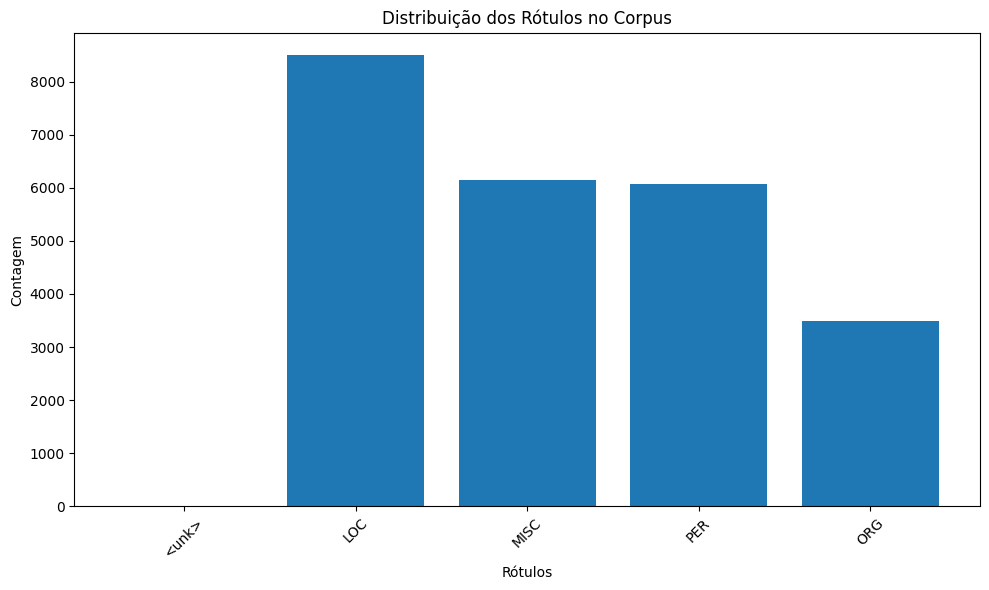

In [8]:
# Obtém o dicionário de rótulos do corpus
label_dictionary = combined_corpus.make_label_dictionary('label')

# Inicializa o dicionário de contagem de rótulos
label_counts = {}

# Percorre os exemplos de treinamento e conta os rótulos
for sentence in combined_corpus.train:
    for label in sentence.get_labels('label'):
        label_counts[label.value] = label_counts.get(label.value, 0) + 1

# Verifica se o rótulo '<unk>' está presente e define sua contagem como 0 se não estiver
if '<unk>' not in label_counts:
    label_counts['<unk>'] = 0

# Extrai os rótulos e as contagens
labels = label_dictionary.get_items()
counts = [label_counts[label] for label in labels]

# Plota o gráfico de barras da distribuição dos rótulos
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Rótulos')
plt.ylabel('Contagem')
plt.title('Distribuição dos Rótulos no Corpus')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

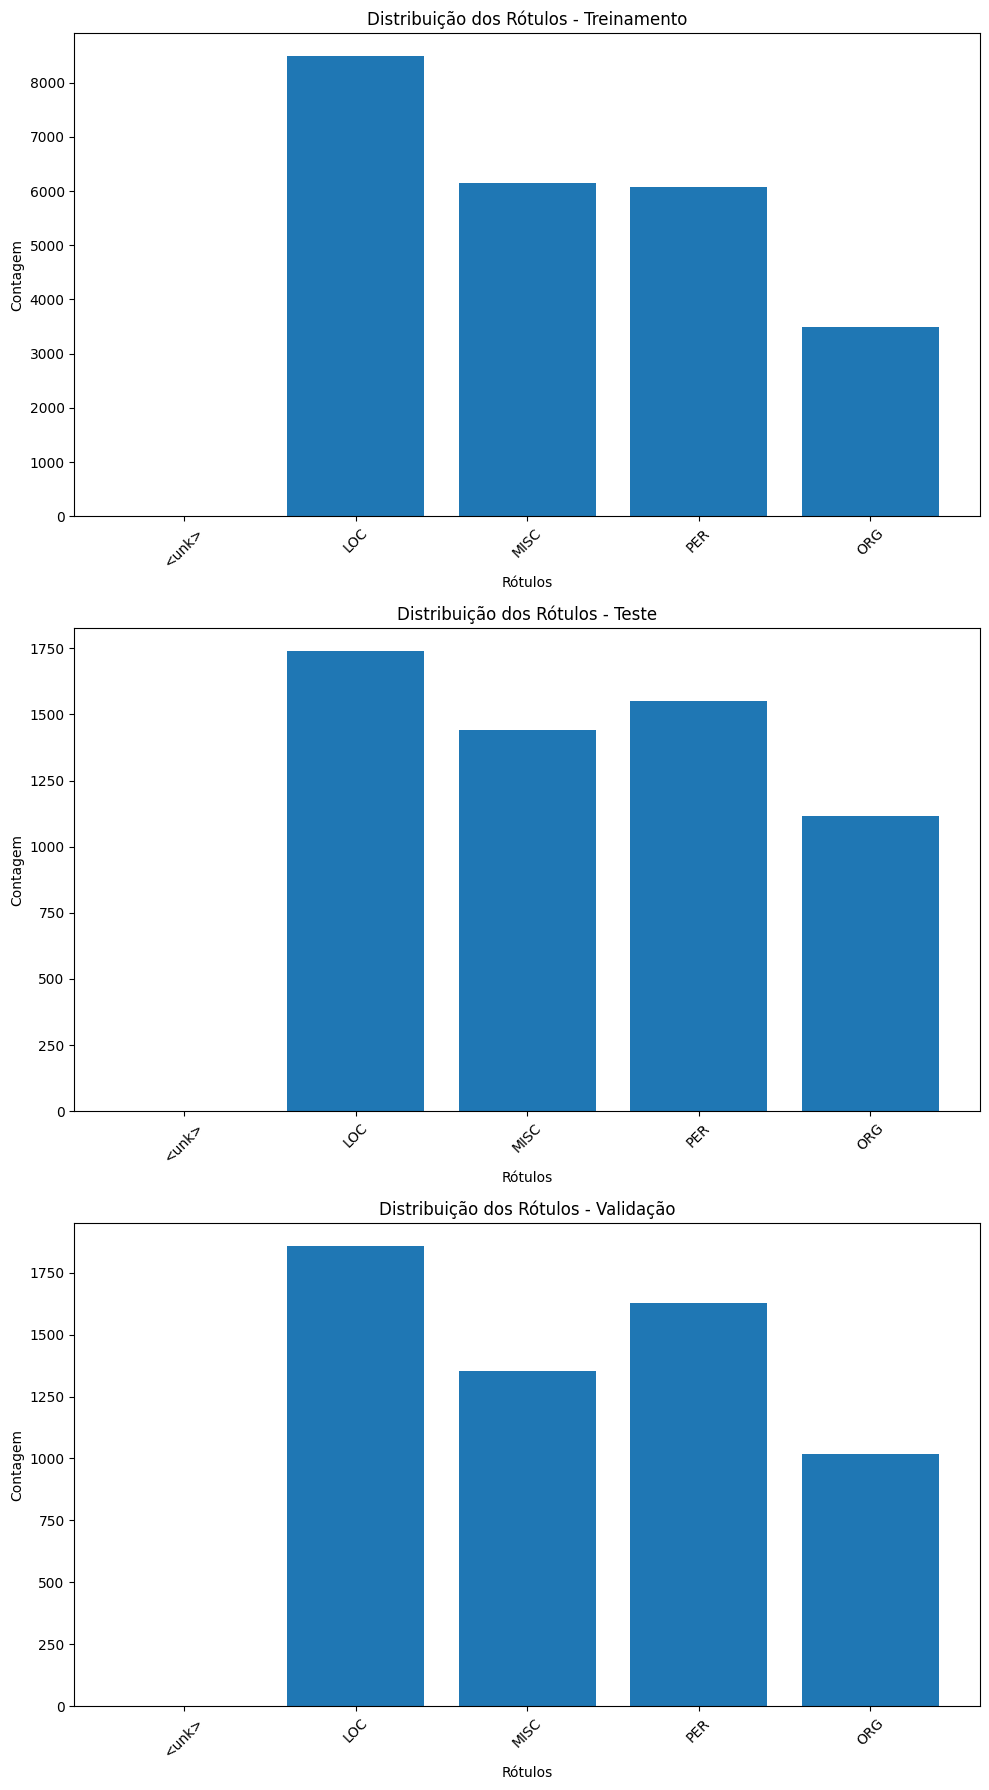

In [9]:
# Inicializa o dicionário de contagem de rótulos para cada conjunto
train_label_counts = {}
test_label_counts = {}
dev_label_counts = {}

# Percorre os exemplos de treinamento e conta os rótulos
for sentence in combined_corpus.train:
    for label in sentence.get_labels('label'):
        train_label_counts[label.value] = train_label_counts.get(label.value, 0) + 1

# Percorre os exemplos de teste e conta os rótulos
for sentence in combined_corpus.test:
    for label in sentence.get_labels('label'):
        test_label_counts[label.value] = test_label_counts.get(label.value, 0) + 1

# Percorre os exemplos de validação e conta os rótulos
for sentence in combined_corpus.dev:
    for label in sentence.get_labels('label'):
        dev_label_counts[label.value] = dev_label_counts.get(label.value, 0) + 1

# Verifica se o rótulo '<unk>' está presente e define sua contagem como 0 se não estiver para cada conjunto
for label_counts in [train_label_counts, test_label_counts, dev_label_counts]:
    if '<unk>' not in label_counts:
        label_counts['<unk>'] = 0

# Extrai os rótulos e as contagens para cada conjunto
train_labels = label_dictionary.get_items()
train_counts = [train_label_counts[label] for label in train_labels]

test_labels = label_dictionary.get_items()
test_counts = [test_label_counts[label] for label in test_labels]

dev_labels = label_dictionary.get_items()
dev_counts = [dev_label_counts[label] for label in dev_labels]

# Plota o gráfico de barras da distribuição dos rótulos para cada conjunto
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

axs[0].bar(train_labels, train_counts)
axs[0].set_xlabel('Rótulos')
axs[0].set_ylabel('Contagem')
axs[0].set_title('Distribuição dos Rótulos - Treinamento')
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(test_labels, test_counts)
axs[1].set_xlabel('Rótulos')
axs[1].set_ylabel('Contagem')
axs[1].set_title('Distribuição dos Rótulos - Teste')
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(dev_labels, dev_counts)
axs[2].set_xlabel('Rótulos')
axs[2].set_ylabel('Contagem')
axs[2].set_title('Distribuição dos Rótulos - Validação')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [10]:
# Define o tipo de tag
tag_type = 'label'

# Cria um dicionário de tags usando o corpus combinado
tag_dictionary = combined_corpus.make_label_dictionary(label_type=tag_type)

# Define os tipos de embeddings desejados
embedding_types: List[TokenEmbeddings] = [
    #WordEmbeddings('glove'),
    FlairEmbeddings('news-forward'),
    FlairEmbeddings('news-backward'),
]

# Cria as embeddings empilhadas
embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)



2023-05-31 17:28:56,095 Computing label dictionary. Progress:


14000it [00:00, 53629.13it/s]

2023-05-31 17:28:56,363 Dictionary created for label 'label' with 5 values: LOC (seen 8494 times), MISC (seen 6143 times), PER (seen 6075 times), ORG (seen 3494 times)


2023-05-31 17:28:56,458 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmps0hysmuh


100%|██████████| 69.7M/69.7M [00:01<00:00, 39.4MB/s]

2023-05-31 17:28:58,378 copying /tmp/tmps0hysmuh to cache at /root/.flair/embeddings/news-forward-0.4.1.pt
2023-05-31 17:28:58,435 removing temp file /tmp/tmps0hysmuh


2023-05-31 17:29:10,462 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmps3bhw4jg


100%|██████████| 69.7M/69.7M [00:01<00:00, 36.7MB/s]

2023-05-31 17:29:12,535 copying /tmp/tmps3bhw4jg to cache at /root/.flair/embeddings/news-backward-0.4.1.pt


2023-05-31 17:29:12,590 removing temp file /tmp/tmps3bhw4jg


In [11]:
# Acesse os tipos de tags presentes no dicionário
tag_types = tag_dictionary.get_items()

# Imprima os tipos de tags
print("Tipos de tags:")
for tag in tag_types:
    print(tag)

Tipos de tags:
<unk>
LOC
MISC
PER
ORG


In [12]:
# Imprime a primeira sentença do conjunto de treinamento convertida em uma sequência de texto com as tags anotadas.
print('\nTrain: ', combined_corpus.train[0].to_tagged_string('label'))

# Imprime a primeira sentença do conjunto de desenvolvimento convertida em uma sequência de texto com as tags anotadas.
print('Dev: ', combined_corpus.dev[0].to_tagged_string('label'))

# Imprime a primeira sentença do conjunto de teste convertida em uma sequência de texto com as tags anotadas.
print('Test: ', combined_corpus.test[0].to_tagged_string('label'))


Train:  Sentence[25]: "There is a large and highly unusual statue of the head of Vladimir Lenin in the central square : the largest in the world ." → ["Vladimir Lenin"/PER]
Dev:  Sentence[56]: "It is customary to have stations in the centre of a city built very deep , not only to minimise disruption , but also , because of the Cold War threat , they were built to double as bomb shelters , and many old stations do feature provisions such as blast doors and air filters ." → ["Cold War"/MISC]
Test:  Sentence[30]: "On Rotten Tomatoes , " Ocean 's 11 " holds a rating of 48 % , based on 31 reviews , with an average rating of 5.33 / 10 ." → ["Rotten Tomatoes"/MISC]


In [13]:
# Importa a classe SequenceTagger do Flair

tagger : SequenceTagger = SequenceTagger(hidden_size=256,
                                       embeddings=embeddings,
                                       tag_dictionary=tag_dictionary,
                                       tag_type=tag_type,
                                       use_crf=True)

# Cria uma instância de SequenceTagger com os seguintes parâmetros:
# - hidden_size: Especifica a dimensão do espaço oculto do modelo.
# - embeddings: Passa o objeto embeddings que contém as embeddings de tokens definidas anteriormente.
# - tag_dictionary: Passa o dicionário de tags criado a partir do corpus usando o método make_tag_dictionary().
# - tag_type: Especifica o tipo de tag que o modelo irá prever.
# - use_crf: Especifica se o modelo deve usar um Conditional Random Field (CRF) para realizar a anotação de sequência.

2023-05-31 17:29:12,839 SequenceTagger predicts: Dictionary with 17 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-MISC, B-MISC, E-MISC, I-MISC, S-PER, B-PER, E-PER, I-PER, S-ORG, B-ORG, E-ORG, I-ORG


In [14]:
# Treinamento do modelo

trainer: ModelTrainer = ModelTrainer(tagger, combined_corpus)
trainer.train('resources/taggers/flair-wikineural',
              learning_rate=0.1,  # Taxa de aprendizado
              mini_batch_size=32,  # Tamanho do mini-batch
              optimizer=SGDW,  # Otimizador
              max_epochs=30)  # Número máximo de épocas

2023-05-31 17:29:13,077 ----------------------------------------------------------------------------------------------------
2023-05-31 17:29:13,078 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4096, out_features=4096, bias=True)
  (rnn): LSTM(4096, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=19, bias=True)
  (loss_function): ViterbiLoss()
  (crf): CRF()
)"
2023-05-31 17:29:13,082 ------------------------------------

/usr/local/lib/python3.10/dist-packages/flair/optim.py:132: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  p.data.add_(-group["lr"], d_p)


2023-05-31 17:29:30,866 epoch 1 - iter 43/438 - loss 0.60947719 - time (sec): 17.75 - samples/sec: 1822.78 - lr: 0.100000
2023-05-31 17:29:50,604 epoch 1 - iter 86/438 - loss 0.41983186 - time (sec): 37.48 - samples/sec: 1735.25 - lr: 0.100000
2023-05-31 17:30:10,945 epoch 1 - iter 129/438 - loss 0.33332942 - time (sec): 57.83 - samples/sec: 1700.13 - lr: 0.100000
2023-05-31 17:30:30,383 epoch 1 - iter 172/438 - loss 0.28342494 - time (sec): 77.26 - samples/sec: 1698.01 - lr: 0.100000
2023-05-31 17:30:51,061 epoch 1 - iter 215/438 - loss 0.25116582 - time (sec): 97.94 - samples/sec: 1678.53 - lr: 0.100000
2023-05-31 17:31:10,397 epoch 1 - iter 258/438 - loss 0.22780956 - time (sec): 117.28 - samples/sec: 1679.62 - lr: 0.100000
2023-05-31 17:31:32,273 epoch 1 - iter 301/438 - loss 0.21030351 - time (sec): 139.15 - samples/sec: 1654.64 - lr: 0.100000
2023-05-31 17:31:51,877 epoch 1 - iter 344/438 - loss 0.19667397 - time (sec): 158.76 - samples/sec: 1657.90 - lr: 0.100000
2023-05-31 17:3

100%|██████████| 110/110 [01:04<00:00,  1.71it/s]

2023-05-31 17:33:41,488 Evaluating as a multi-label problem: False
2023-05-31 17:33:41,542 DEV : loss 0.06970632076263428 - f1-score (micro avg)  0.7922


2023-05-31 17:33:41,781 BAD EPOCHS (no improvement): 0
2023-05-31 17:33:41,783 saving best model
2023-05-31 17:33:42,267 ----------------------------------------------------------------------------------------------------
2023-05-31 17:33:47,704 epoch 2 - iter 43/438 - loss 0.09415284 - time (sec): 5.44 - samples/sec: 6019.32 - lr: 0.100000
2023-05-31 17:33:53,279 epoch 2 - iter 86/438 - loss 0.09103178 - time (sec): 11.01 - samples/sec: 5911.21 - lr: 0.100000
2023-05-31 17:33:58,609 epoch 2 - iter 129/438 - loss 0.08956326 - time (sec): 16.34 - samples/sec: 5959.99 - lr: 0.100000
2023-05-31 17:34:04,694 epoch 2 - iter 172/438 - loss 0.08784311 - time (sec): 22.43 - samples/sec: 5837.92 - lr: 0.100000
2023-05-31 17:34:10,022 epoch 2 - iter 215/438 - loss 0.08629667 - time (sec): 27.75 - samples/sec: 5890.57 - lr: 0.100000
2023-05-31 17:34:15,582 epoch 2 - iter 258/438 - loss 0.08578773 - time (sec): 33.31 - samples/sec: 5914.64 - lr: 0.100000
2023-05-31 17:34:21,120 epoch 2 - iter 301/

100%|██████████| 110/110 [00:20<00:00,  5.43it/s]

2023-05-31 17:34:58,660 Evaluating as a multi-label problem: False
2023-05-31 17:34:58,708 DEV : loss 0.055137842893600464 - f1-score (micro avg)  0.8124


2023-05-31 17:34:58,946 BAD EPOCHS (no improvement): 0
2023-05-31 17:34:58,948 saving best model
2023-05-31 17:34:59,440 ----------------------------------------------------------------------------------------------------
2023-05-31 17:35:05,437 epoch 3 - iter 43/438 - loss 0.07631155 - time (sec): 6.00 - samples/sec: 5468.80 - lr: 0.100000
2023-05-31 17:35:11,077 epoch 3 - iter 86/438 - loss 0.07399180 - time (sec): 11.64 - samples/sec: 5624.70 - lr: 0.100000
2023-05-31 17:35:16,715 epoch 3 - iter 129/438 - loss 0.07270608 - time (sec): 17.27 - samples/sec: 5718.62 - lr: 0.100000
2023-05-31 17:35:22,245 epoch 3 - iter 172/438 - loss 0.07343325 - time (sec): 22.80 - samples/sec: 5790.34 - lr: 0.100000
2023-05-31 17:35:27,750 epoch 3 - iter 215/438 - loss 0.07133854 - time (sec): 28.31 - samples/sec: 5816.24 - lr: 0.100000
2023-05-31 17:35:33,069 epoch 3 - iter 258/438 - loss 0.07066915 - time (sec): 33.63 - samples/sec: 5864.27 - lr: 0.100000
2023-05-31 17:35:38,565 epoch 3 - iter 301/

100%|██████████| 110/110 [00:20<00:00,  5.45it/s]

2023-05-31 17:36:16,530 Evaluating as a multi-label problem: False
2023-05-31 17:36:16,577 DEV : loss 0.05064845085144043 - f1-score (micro avg)  0.819


2023-05-31 17:36:16,801 BAD EPOCHS (no improvement): 0
2023-05-31 17:36:16,803 saving best model
2023-05-31 17:36:17,310 ----------------------------------------------------------------------------------------------------
2023-05-31 17:36:22,871 epoch 4 - iter 43/438 - loss 0.06464226 - time (sec): 5.56 - samples/sec: 5860.71 - lr: 0.100000
2023-05-31 17:36:28,701 epoch 4 - iter 86/438 - loss 0.06248356 - time (sec): 11.39 - samples/sec: 5762.36 - lr: 0.100000
2023-05-31 17:36:33,984 epoch 4 - iter 129/438 - loss 0.06182171 - time (sec): 16.67 - samples/sec: 5897.46 - lr: 0.100000
2023-05-31 17:36:39,445 epoch 4 - iter 172/438 - loss 0.06067235 - time (sec): 22.13 - samples/sec: 5935.70 - lr: 0.100000
2023-05-31 17:36:44,816 epoch 4 - iter 215/438 - loss 0.06099103 - time (sec): 27.50 - samples/sec: 5946.70 - lr: 0.100000
2023-05-31 17:36:50,235 epoch 4 - iter 258/438 - loss 0.06107639 - time (sec): 32.92 - samples/sec: 5976.94 - lr: 0.100000
2023-05-31 17:36:55,901 epoch 4 - iter 301/

100%|██████████| 110/110 [00:20<00:00,  5.33it/s]

2023-05-31 17:37:33,808 Evaluating as a multi-label problem: False
2023-05-31 17:37:33,865 DEV : loss 0.04570441693067551 - f1-score (micro avg)  0.8433


2023-05-31 17:37:34,105 BAD EPOCHS (no improvement): 0
2023-05-31 17:37:34,107 saving best model
2023-05-31 17:37:34,615 ----------------------------------------------------------------------------------------------------
2023-05-31 17:37:40,059 epoch 5 - iter 43/438 - loss 0.05609153 - time (sec): 5.44 - samples/sec: 6133.65 - lr: 0.100000
2023-05-31 17:37:45,264 epoch 5 - iter 86/438 - loss 0.05600296 - time (sec): 10.65 - samples/sec: 6208.39 - lr: 0.100000
2023-05-31 17:37:51,047 epoch 5 - iter 129/438 - loss 0.05423299 - time (sec): 16.43 - samples/sec: 6038.59 - lr: 0.100000
2023-05-31 17:37:56,904 epoch 5 - iter 172/438 - loss 0.05412165 - time (sec): 22.29 - samples/sec: 5950.00 - lr: 0.100000
2023-05-31 17:38:02,447 epoch 5 - iter 215/438 - loss 0.05411748 - time (sec): 27.83 - samples/sec: 5938.16 - lr: 0.100000
2023-05-31 17:38:07,902 epoch 5 - iter 258/438 - loss 0.05455246 - time (sec): 33.28 - samples/sec: 5951.75 - lr: 0.100000
2023-05-31 17:38:13,173 epoch 5 - iter 301/

100%|██████████| 110/110 [00:20<00:00,  5.34it/s]

2023-05-31 17:38:51,711 Evaluating as a multi-label problem: False
2023-05-31 17:38:51,766 DEV : loss 0.043715305626392365 - f1-score (micro avg)  0.8494


2023-05-31 17:38:52,003 BAD EPOCHS (no improvement): 0
2023-05-31 17:38:52,005 saving best model
2023-05-31 17:38:52,542 ----------------------------------------------------------------------------------------------------
2023-05-31 17:38:58,857 epoch 6 - iter 43/438 - loss 0.05004825 - time (sec): 6.31 - samples/sec: 5330.46 - lr: 0.100000
2023-05-31 17:39:04,693 epoch 6 - iter 86/438 - loss 0.05181225 - time (sec): 12.15 - samples/sec: 5490.27 - lr: 0.100000
2023-05-31 17:39:10,348 epoch 6 - iter 129/438 - loss 0.05179535 - time (sec): 17.80 - samples/sec: 5632.03 - lr: 0.100000
2023-05-31 17:39:15,662 epoch 6 - iter 172/438 - loss 0.05209010 - time (sec): 23.12 - samples/sec: 5749.29 - lr: 0.100000
2023-05-31 17:39:21,624 epoch 6 - iter 215/438 - loss 0.05195244 - time (sec): 29.08 - samples/sec: 5713.44 - lr: 0.100000
2023-05-31 17:39:26,922 epoch 6 - iter 258/438 - loss 0.05277580 - time (sec): 34.38 - samples/sec: 5766.82 - lr: 0.100000
2023-05-31 17:39:32,761 epoch 6 - iter 301/

100%|██████████| 110/110 [00:20<00:00,  5.40it/s]

2023-05-31 17:40:10,608 Evaluating as a multi-label problem: False
2023-05-31 17:40:10,675 DEV : loss 0.04221685230731964 - f1-score (micro avg)  0.8502


2023-05-31 17:40:10,919 BAD EPOCHS (no improvement): 0
2023-05-31 17:40:10,921 saving best model
2023-05-31 17:40:11,446 ----------------------------------------------------------------------------------------------------
2023-05-31 17:40:17,247 epoch 7 - iter 43/438 - loss 0.04739026 - time (sec): 5.80 - samples/sec: 5752.94 - lr: 0.100000
2023-05-31 17:40:22,893 epoch 7 - iter 86/438 - loss 0.04639270 - time (sec): 11.44 - samples/sec: 5788.08 - lr: 0.100000
2023-05-31 17:40:28,612 epoch 7 - iter 129/438 - loss 0.04766087 - time (sec): 17.16 - samples/sec: 5767.02 - lr: 0.100000
2023-05-31 17:40:34,180 epoch 7 - iter 172/438 - loss 0.04784825 - time (sec): 22.73 - samples/sec: 5789.57 - lr: 0.100000
2023-05-31 17:40:40,036 epoch 7 - iter 215/438 - loss 0.04814148 - time (sec): 28.59 - samples/sec: 5742.24 - lr: 0.100000
2023-05-31 17:40:45,618 epoch 7 - iter 258/438 - loss 0.04807829 - time (sec): 34.17 - samples/sec: 5766.29 - lr: 0.100000
2023-05-31 17:40:51,682 epoch 7 - iter 301/

100%|██████████| 110/110 [00:21<00:00,  5.23it/s]

2023-05-31 17:41:29,954 Evaluating as a multi-label problem: False
2023-05-31 17:41:30,002 DEV : loss 0.04199768975377083 - f1-score (micro avg)  0.854


2023-05-31 17:41:30,244 BAD EPOCHS (no improvement): 0
2023-05-31 17:41:30,246 saving best model
2023-05-31 17:41:30,758 ----------------------------------------------------------------------------------------------------
2023-05-31 17:41:36,438 epoch 8 - iter 43/438 - loss 0.04217385 - time (sec): 5.68 - samples/sec: 5786.47 - lr: 0.100000
2023-05-31 17:41:41,916 epoch 8 - iter 86/438 - loss 0.04434910 - time (sec): 11.15 - samples/sec: 5970.81 - lr: 0.100000
2023-05-31 17:41:47,500 epoch 8 - iter 129/438 - loss 0.04634958 - time (sec): 16.74 - samples/sec: 5909.61 - lr: 0.100000
2023-05-31 17:41:53,039 epoch 8 - iter 172/438 - loss 0.04570168 - time (sec): 22.28 - samples/sec: 5944.19 - lr: 0.100000
2023-05-31 17:41:58,293 epoch 8 - iter 215/438 - loss 0.04683562 - time (sec): 27.53 - samples/sec: 5981.19 - lr: 0.100000
2023-05-31 17:42:03,746 epoch 8 - iter 258/438 - loss 0.04697641 - time (sec): 32.98 - samples/sec: 5988.58 - lr: 0.100000
2023-05-31 17:42:09,349 epoch 8 - iter 301/

100%|██████████| 110/110 [00:30<00:00,  3.58it/s]

2023-05-31 17:42:57,607 Evaluating as a multi-label problem: False
2023-05-31 17:42:57,659 DEV : loss 0.04054354503750801 - f1-score (micro avg)  0.8626


2023-05-31 17:42:57,902 BAD EPOCHS (no improvement): 0
2023-05-31 17:42:57,904 saving best model
2023-05-31 17:42:58,395 ----------------------------------------------------------------------------------------------------
2023-05-31 17:43:04,261 epoch 9 - iter 43/438 - loss 0.04501226 - time (sec): 5.86 - samples/sec: 5697.84 - lr: 0.100000
2023-05-31 17:43:09,941 epoch 9 - iter 86/438 - loss 0.04390365 - time (sec): 11.54 - samples/sec: 5740.16 - lr: 0.100000
2023-05-31 17:43:15,969 epoch 9 - iter 129/438 - loss 0.04453866 - time (sec): 17.57 - samples/sec: 5658.82 - lr: 0.100000
2023-05-31 17:43:21,407 epoch 9 - iter 172/438 - loss 0.04399103 - time (sec): 23.01 - samples/sec: 5749.33 - lr: 0.100000
2023-05-31 17:43:26,833 epoch 9 - iter 215/438 - loss 0.04381486 - time (sec): 28.44 - samples/sec: 5794.13 - lr: 0.100000
2023-05-31 17:43:32,165 epoch 9 - iter 258/438 - loss 0.04410199 - time (sec): 33.77 - samples/sec: 5846.75 - lr: 0.100000
2023-05-31 17:43:37,597 epoch 9 - iter 301/

100%|██████████| 110/110 [00:19<00:00,  5.59it/s]

2023-05-31 17:44:14,821 Evaluating as a multi-label problem: False
2023-05-31 17:44:14,879 DEV : loss 0.03966616466641426 - f1-score (micro avg)  0.8596


2023-05-31 17:44:15,128 BAD EPOCHS (no improvement): 1
2023-05-31 17:44:15,131 ----------------------------------------------------------------------------------------------------
2023-05-31 17:44:20,927 epoch 10 - iter 43/438 - loss 0.04361040 - time (sec): 5.80 - samples/sec: 5633.59 - lr: 0.100000
2023-05-31 17:44:26,565 epoch 10 - iter 86/438 - loss 0.04147709 - time (sec): 11.43 - samples/sec: 5744.56 - lr: 0.100000
2023-05-31 17:44:31,911 epoch 10 - iter 129/438 - loss 0.04170984 - time (sec): 16.78 - samples/sec: 5899.72 - lr: 0.100000
2023-05-31 17:44:37,458 epoch 10 - iter 172/438 - loss 0.04149065 - time (sec): 22.33 - samples/sec: 5906.37 - lr: 0.100000
2023-05-31 17:44:43,263 epoch 10 - iter 215/438 - loss 0.04134710 - time (sec): 28.13 - samples/sec: 5871.24 - lr: 0.100000
2023-05-31 17:44:48,700 epoch 10 - iter 258/438 - loss 0.04159476 - time (sec): 33.57 - samples/sec: 5891.13 - lr: 0.100000
2023-05-31 17:44:54,330 epoch 10 - iter 301/438 - loss 0.04180566 - time (sec):

100%|██████████| 110/110 [00:20<00:00,  5.43it/s]

2023-05-31 17:45:32,160 Evaluating as a multi-label problem: False
2023-05-31 17:45:32,206 DEV : loss 0.0371476411819458 - f1-score (micro avg)  0.8682


2023-05-31 17:45:32,427 BAD EPOCHS (no improvement): 0
2023-05-31 17:45:32,429 saving best model
2023-05-31 17:45:32,983 ----------------------------------------------------------------------------------------------------
2023-05-31 17:45:38,552 epoch 11 - iter 43/438 - loss 0.04113357 - time (sec): 5.57 - samples/sec: 5812.88 - lr: 0.100000
2023-05-31 17:45:44,303 epoch 11 - iter 86/438 - loss 0.04056860 - time (sec): 11.32 - samples/sec: 5787.59 - lr: 0.100000
2023-05-31 17:45:50,001 epoch 11 - iter 129/438 - loss 0.04053833 - time (sec): 17.02 - samples/sec: 5786.98 - lr: 0.100000
2023-05-31 17:45:55,431 epoch 11 - iter 172/438 - loss 0.04025440 - time (sec): 22.45 - samples/sec: 5866.19 - lr: 0.100000
2023-05-31 17:46:00,856 epoch 11 - iter 215/438 - loss 0.03992538 - time (sec): 27.87 - samples/sec: 5920.65 - lr: 0.100000
2023-05-31 17:46:06,456 epoch 11 - iter 258/438 - loss 0.04037000 - time (sec): 33.47 - samples/sec: 5905.73 - lr: 0.100000
2023-05-31 17:46:11,969 epoch 11 - it

100%|██████████| 110/110 [00:20<00:00,  5.31it/s]

2023-05-31 17:46:50,487 Evaluating as a multi-label problem: False
2023-05-31 17:46:50,536 DEV : loss 0.04037047550082207 - f1-score (micro avg)  0.8635


2023-05-31 17:46:50,762 BAD EPOCHS (no improvement): 1
2023-05-31 17:46:50,764 ----------------------------------------------------------------------------------------------------
2023-05-31 17:46:56,262 epoch 12 - iter 43/438 - loss 0.03809724 - time (sec): 5.50 - samples/sec: 5911.67 - lr: 0.100000
2023-05-31 17:47:01,929 epoch 12 - iter 86/438 - loss 0.03838176 - time (sec): 11.16 - samples/sec: 5904.68 - lr: 0.100000
2023-05-31 17:47:07,315 epoch 12 - iter 129/438 - loss 0.03909607 - time (sec): 16.55 - samples/sec: 5982.47 - lr: 0.100000
2023-05-31 17:47:12,743 epoch 12 - iter 172/438 - loss 0.03909316 - time (sec): 21.98 - samples/sec: 6008.16 - lr: 0.100000
2023-05-31 17:47:18,211 epoch 12 - iter 215/438 - loss 0.03834164 - time (sec): 27.45 - samples/sec: 6030.50 - lr: 0.100000
2023-05-31 17:47:24,399 epoch 12 - iter 258/438 - loss 0.03785367 - time (sec): 33.63 - samples/sec: 5926.54 - lr: 0.100000
2023-05-31 17:47:29,998 epoch 12 - iter 301/438 - loss 0.03787285 - time (sec):

100%|██████████| 110/110 [00:20<00:00,  5.47it/s]

2023-05-31 17:48:07,685 Evaluating as a multi-label problem: False
2023-05-31 17:48:07,733 DEV : loss 0.03889809548854828 - f1-score (micro avg)  0.8613


2023-05-31 17:48:07,963 BAD EPOCHS (no improvement): 2
2023-05-31 17:48:07,965 ----------------------------------------------------------------------------------------------------
2023-05-31 17:48:13,881 epoch 13 - iter 43/438 - loss 0.03618050 - time (sec): 5.91 - samples/sec: 5630.28 - lr: 0.100000
2023-05-31 17:48:19,496 epoch 13 - iter 86/438 - loss 0.03416497 - time (sec): 11.53 - samples/sec: 5716.71 - lr: 0.100000
2023-05-31 17:48:25,056 epoch 13 - iter 129/438 - loss 0.03616714 - time (sec): 17.09 - samples/sec: 5792.04 - lr: 0.100000
2023-05-31 17:48:30,408 epoch 13 - iter 172/438 - loss 0.03656697 - time (sec): 22.44 - samples/sec: 5859.78 - lr: 0.100000
2023-05-31 17:48:35,865 epoch 13 - iter 215/438 - loss 0.03702466 - time (sec): 27.90 - samples/sec: 5881.48 - lr: 0.100000
2023-05-31 17:48:41,376 epoch 13 - iter 258/438 - loss 0.03699304 - time (sec): 33.41 - samples/sec: 5891.63 - lr: 0.100000
2023-05-31 17:48:46,991 epoch 13 - iter 301/438 - loss 0.03730243 - time (sec):

100%|██████████| 110/110 [00:20<00:00,  5.29it/s]

2023-05-31 17:49:26,471 Evaluating as a multi-label problem: False
2023-05-31 17:49:26,520 DEV : loss 0.03731432184576988 - f1-score (micro avg)  0.87


2023-05-31 17:49:26,766 BAD EPOCHS (no improvement): 0
2023-05-31 17:49:26,768 saving best model
2023-05-31 17:49:27,278 ----------------------------------------------------------------------------------------------------
2023-05-31 17:49:32,797 epoch 14 - iter 43/438 - loss 0.03497747 - time (sec): 5.52 - samples/sec: 5871.25 - lr: 0.100000
2023-05-31 17:49:38,190 epoch 14 - iter 86/438 - loss 0.03548869 - time (sec): 10.91 - samples/sec: 5952.20 - lr: 0.100000
2023-05-31 17:49:43,713 epoch 14 - iter 129/438 - loss 0.03576385 - time (sec): 16.43 - samples/sec: 5937.26 - lr: 0.100000
2023-05-31 17:49:49,311 epoch 14 - iter 172/438 - loss 0.03595129 - time (sec): 22.03 - samples/sec: 5894.72 - lr: 0.100000
2023-05-31 17:49:54,838 epoch 14 - iter 215/438 - loss 0.03571175 - time (sec): 27.56 - samples/sec: 5945.29 - lr: 0.100000
2023-05-31 17:50:00,470 epoch 14 - iter 258/438 - loss 0.03582118 - time (sec): 33.19 - samples/sec: 5924.76 - lr: 0.100000
2023-05-31 17:50:06,345 epoch 14 - it

100%|██████████| 110/110 [00:20<00:00,  5.40it/s]

2023-05-31 17:50:44,550 Evaluating as a multi-label problem: False
2023-05-31 17:50:44,604 DEV : loss 0.039340950548648834 - f1-score (micro avg)  0.8678


2023-05-31 17:50:44,829 BAD EPOCHS (no improvement): 1
2023-05-31 17:50:44,831 ----------------------------------------------------------------------------------------------------
2023-05-31 17:50:50,627 epoch 15 - iter 43/438 - loss 0.03441440 - time (sec): 5.79 - samples/sec: 5764.28 - lr: 0.100000
2023-05-31 17:50:56,210 epoch 15 - iter 86/438 - loss 0.03312483 - time (sec): 11.38 - samples/sec: 5858.85 - lr: 0.100000
2023-05-31 17:51:01,574 epoch 15 - iter 129/438 - loss 0.03463428 - time (sec): 16.74 - samples/sec: 5958.83 - lr: 0.100000
2023-05-31 17:51:06,784 epoch 15 - iter 172/438 - loss 0.03421253 - time (sec): 21.95 - samples/sec: 6004.71 - lr: 0.100000
2023-05-31 17:51:12,264 epoch 15 - iter 215/438 - loss 0.03460041 - time (sec): 27.43 - samples/sec: 6004.96 - lr: 0.100000
2023-05-31 17:51:17,703 epoch 15 - iter 258/438 - loss 0.03451590 - time (sec): 32.87 - samples/sec: 6014.42 - lr: 0.100000
2023-05-31 17:51:23,036 epoch 15 - iter 301/438 - loss 0.03414382 - time (sec):

100%|██████████| 110/110 [00:30<00:00,  3.59it/s]

2023-05-31 17:52:11,612 Evaluating as a multi-label problem: False
2023-05-31 17:52:11,667 DEV : loss 0.04010123386979103 - f1-score (micro avg)  0.869


2023-05-31 17:52:11,919 BAD EPOCHS (no improvement): 2
2023-05-31 17:52:11,921 ----------------------------------------------------------------------------------------------------
2023-05-31 17:52:17,783 epoch 16 - iter 43/438 - loss 0.03578983 - time (sec): 5.86 - samples/sec: 5672.27 - lr: 0.100000
2023-05-31 17:52:23,134 epoch 16 - iter 86/438 - loss 0.03460271 - time (sec): 11.21 - samples/sec: 5898.83 - lr: 0.100000
2023-05-31 17:52:28,529 epoch 16 - iter 129/438 - loss 0.03360248 - time (sec): 16.61 - samples/sec: 5973.75 - lr: 0.100000
2023-05-31 17:52:34,319 epoch 16 - iter 172/438 - loss 0.03348686 - time (sec): 22.40 - samples/sec: 5909.31 - lr: 0.100000
2023-05-31 17:52:39,449 epoch 16 - iter 215/438 - loss 0.03322132 - time (sec): 27.53 - samples/sec: 5988.65 - lr: 0.100000
2023-05-31 17:52:45,168 epoch 16 - iter 258/438 - loss 0.03297777 - time (sec): 33.25 - samples/sec: 5948.50 - lr: 0.100000
2023-05-31 17:52:50,795 epoch 16 - iter 301/438 - loss 0.03312174 - time (sec):

100%|██████████| 110/110 [00:20<00:00,  5.42it/s]

2023-05-31 17:53:28,289 Evaluating as a multi-label problem: False
2023-05-31 17:53:28,337 DEV : loss 0.037404805421829224 - f1-score (micro avg)  0.8722


2023-05-31 17:53:28,594 BAD EPOCHS (no improvement): 0
2023-05-31 17:53:28,598 saving best model
2023-05-31 17:53:29,100 ----------------------------------------------------------------------------------------------------
2023-05-31 17:53:35,141 epoch 17 - iter 43/438 - loss 0.02939761 - time (sec): 6.04 - samples/sec: 5443.31 - lr: 0.100000
2023-05-31 17:53:40,710 epoch 17 - iter 86/438 - loss 0.02977912 - time (sec): 11.61 - samples/sec: 5633.95 - lr: 0.100000
2023-05-31 17:53:46,477 epoch 17 - iter 129/438 - loss 0.03130101 - time (sec): 17.38 - samples/sec: 5678.11 - lr: 0.100000
2023-05-31 17:53:52,141 epoch 17 - iter 172/438 - loss 0.03104305 - time (sec): 23.04 - samples/sec: 5723.66 - lr: 0.100000
2023-05-31 17:53:57,629 epoch 17 - iter 215/438 - loss 0.03118339 - time (sec): 28.53 - samples/sec: 5786.53 - lr: 0.100000
2023-05-31 17:54:02,964 epoch 17 - iter 258/438 - loss 0.03140214 - time (sec): 33.86 - samples/sec: 5832.99 - lr: 0.100000
2023-05-31 17:54:08,590 epoch 17 - it

100%|██████████| 110/110 [00:20<00:00,  5.28it/s]

2023-05-31 17:54:46,846 Evaluating as a multi-label problem: False
2023-05-31 17:54:46,900 DEV : loss 0.03779932111501694 - f1-score (micro avg)  0.8784


2023-05-31 17:54:47,129 BAD EPOCHS (no improvement): 0
2023-05-31 17:54:47,131 saving best model
2023-05-31 17:54:47,605 ----------------------------------------------------------------------------------------------------
2023-05-31 17:54:53,319 epoch 18 - iter 43/438 - loss 0.03384944 - time (sec): 5.71 - samples/sec: 5774.41 - lr: 0.100000
2023-05-31 17:54:58,768 epoch 18 - iter 86/438 - loss 0.03262402 - time (sec): 11.16 - samples/sec: 5873.15 - lr: 0.100000
2023-05-31 17:55:04,209 epoch 18 - iter 129/438 - loss 0.03211468 - time (sec): 16.60 - samples/sec: 5889.13 - lr: 0.100000
2023-05-31 17:55:09,601 epoch 18 - iter 172/438 - loss 0.03253892 - time (sec): 21.99 - samples/sec: 5929.34 - lr: 0.100000
2023-05-31 17:55:14,934 epoch 18 - iter 215/438 - loss 0.03260560 - time (sec): 27.33 - samples/sec: 5975.44 - lr: 0.100000
2023-05-31 17:55:20,545 epoch 18 - iter 258/438 - loss 0.03257363 - time (sec): 32.94 - samples/sec: 5955.31 - lr: 0.100000
2023-05-31 17:55:26,180 epoch 18 - it

100%|██████████| 110/110 [00:20<00:00,  5.37it/s]

2023-05-31 17:56:05,542 Evaluating as a multi-label problem: False
2023-05-31 17:56:05,591 DEV : loss 0.03956102207303047 - f1-score (micro avg)  0.8746


2023-05-31 17:56:05,844 BAD EPOCHS (no improvement): 1
2023-05-31 17:56:05,846 ----------------------------------------------------------------------------------------------------
2023-05-31 17:56:11,282 epoch 19 - iter 43/438 - loss 0.02793507 - time (sec): 5.44 - samples/sec: 6049.84 - lr: 0.100000
2023-05-31 17:56:17,032 epoch 19 - iter 86/438 - loss 0.02762184 - time (sec): 11.18 - samples/sec: 5925.18 - lr: 0.100000
2023-05-31 17:56:22,183 epoch 19 - iter 129/438 - loss 0.02845768 - time (sec): 16.34 - samples/sec: 6026.44 - lr: 0.100000
2023-05-31 17:56:27,937 epoch 19 - iter 172/438 - loss 0.02906568 - time (sec): 22.09 - samples/sec: 5948.96 - lr: 0.100000
2023-05-31 17:56:33,532 epoch 19 - iter 215/438 - loss 0.02938836 - time (sec): 27.68 - samples/sec: 5941.00 - lr: 0.100000
2023-05-31 17:56:39,178 epoch 19 - iter 258/438 - loss 0.02994691 - time (sec): 33.33 - samples/sec: 5922.59 - lr: 0.100000
2023-05-31 17:56:45,168 epoch 19 - iter 301/438 - loss 0.02993230 - time (sec):

100%|██████████| 110/110 [00:20<00:00,  5.31it/s]

2023-05-31 17:57:23,942 Evaluating as a multi-label problem: False
2023-05-31 17:57:23,993 DEV : loss 0.03815709799528122 - f1-score (micro avg)  0.8749


2023-05-31 17:57:24,254 BAD EPOCHS (no improvement): 2
2023-05-31 17:57:24,256 ----------------------------------------------------------------------------------------------------
2023-05-31 17:57:30,052 epoch 20 - iter 43/438 - loss 0.02840612 - time (sec): 5.80 - samples/sec: 5669.51 - lr: 0.100000
2023-05-31 17:57:35,455 epoch 20 - iter 86/438 - loss 0.02839994 - time (sec): 11.20 - samples/sec: 5800.30 - lr: 0.100000
2023-05-31 17:57:40,951 epoch 20 - iter 129/438 - loss 0.02803542 - time (sec): 16.69 - samples/sec: 5865.03 - lr: 0.100000
2023-05-31 17:57:46,694 epoch 20 - iter 172/438 - loss 0.02816730 - time (sec): 22.44 - samples/sec: 5821.52 - lr: 0.100000
2023-05-31 17:57:51,942 epoch 20 - iter 215/438 - loss 0.02822808 - time (sec): 27.68 - samples/sec: 5915.71 - lr: 0.100000
2023-05-31 17:57:57,239 epoch 20 - iter 258/438 - loss 0.02843515 - time (sec): 32.98 - samples/sec: 5962.52 - lr: 0.100000
2023-05-31 17:58:02,921 epoch 20 - iter 301/438 - loss 0.02849907 - time (sec):

100%|██████████| 110/110 [00:20<00:00,  5.42it/s]

2023-05-31 17:58:41,228 Evaluating as a multi-label problem: False
2023-05-31 17:58:41,278 DEV : loss 0.038006845861673355 - f1-score (micro avg)  0.875


2023-05-31 17:58:41,506 BAD EPOCHS (no improvement): 3
2023-05-31 17:58:41,507 ----------------------------------------------------------------------------------------------------
2023-05-31 17:58:47,127 epoch 21 - iter 43/438 - loss 0.03069622 - time (sec): 5.62 - samples/sec: 5842.06 - lr: 0.100000
2023-05-31 17:58:53,239 epoch 21 - iter 86/438 - loss 0.02928386 - time (sec): 11.73 - samples/sec: 5649.28 - lr: 0.100000
2023-05-31 17:58:58,987 epoch 21 - iter 129/438 - loss 0.03017488 - time (sec): 17.48 - samples/sec: 5704.28 - lr: 0.100000
2023-05-31 17:59:04,456 epoch 21 - iter 172/438 - loss 0.03031320 - time (sec): 22.95 - samples/sec: 5776.29 - lr: 0.100000
2023-05-31 17:59:10,017 epoch 21 - iter 215/438 - loss 0.03027844 - time (sec): 28.51 - samples/sec: 5801.22 - lr: 0.100000
2023-05-31 17:59:15,630 epoch 21 - iter 258/438 - loss 0.03018805 - time (sec): 34.12 - samples/sec: 5814.38 - lr: 0.100000
2023-05-31 17:59:21,048 epoch 21 - iter 301/438 - loss 0.02975962 - time (sec):

100%|██████████| 110/110 [00:20<00:00,  5.31it/s]

2023-05-31 17:59:59,421 Evaluating as a multi-label problem: False
2023-05-31 17:59:59,471 DEV : loss 0.03796042874455452 - f1-score (micro avg)  0.8754


2023-05-31 17:59:59,720 Epoch    21: reducing learning rate of group 0 to 5.0000e-02.
2023-05-31 17:59:59,722 BAD EPOCHS (no improvement): 4
2023-05-31 17:59:59,724 ----------------------------------------------------------------------------------------------------
2023-05-31 18:00:05,321 epoch 22 - iter 43/438 - loss 0.02540743 - time (sec): 5.59 - samples/sec: 5837.69 - lr: 0.050000
2023-05-31 18:00:11,391 epoch 22 - iter 86/438 - loss 0.02556033 - time (sec): 11.66 - samples/sec: 5641.53 - lr: 0.050000
2023-05-31 18:00:16,784 epoch 22 - iter 129/438 - loss 0.02570362 - time (sec): 17.06 - samples/sec: 5772.20 - lr: 0.050000
2023-05-31 18:00:22,260 epoch 22 - iter 172/438 - loss 0.02601279 - time (sec): 22.53 - samples/sec: 5815.79 - lr: 0.050000
2023-05-31 18:00:28,037 epoch 22 - iter 215/438 - loss 0.02589085 - time (sec): 28.31 - samples/sec: 5791.32 - lr: 0.050000
2023-05-31 18:00:33,254 epoch 22 - iter 258/438 - loss 0.02529036 - time (sec): 33.53 - samples/sec: 5882.70 - lr: 0.

100%|██████████| 110/110 [00:31<00:00,  3.53it/s]

2023-05-31 18:01:27,621 Evaluating as a multi-label problem: False
2023-05-31 18:01:27,671 DEV : loss 0.03687196224927902 - f1-score (micro avg)  0.8799


2023-05-31 18:01:27,911 BAD EPOCHS (no improvement): 0
2023-05-31 18:01:27,914 saving best model
2023-05-31 18:01:33,356 ----------------------------------------------------------------------------------------------------
2023-05-31 18:01:38,918 epoch 23 - iter 43/438 - loss 0.02469538 - time (sec): 5.56 - samples/sec: 5742.46 - lr: 0.050000
2023-05-31 18:01:44,933 epoch 23 - iter 86/438 - loss 0.02465896 - time (sec): 11.57 - samples/sec: 5660.86 - lr: 0.050000
2023-05-31 18:01:50,246 epoch 23 - iter 129/438 - loss 0.02512674 - time (sec): 16.89 - samples/sec: 5819.19 - lr: 0.050000
2023-05-31 18:01:55,657 epoch 23 - iter 172/438 - loss 0.02534263 - time (sec): 22.30 - samples/sec: 5861.25 - lr: 0.050000
2023-05-31 18:02:01,119 epoch 23 - iter 215/438 - loss 0.02492367 - time (sec): 27.76 - samples/sec: 5896.32 - lr: 0.050000
2023-05-31 18:02:06,563 epoch 23 - iter 258/438 - loss 0.02506579 - time (sec): 33.20 - samples/sec: 5927.00 - lr: 0.050000
2023-05-31 18:02:12,159 epoch 23 - it

100%|██████████| 110/110 [00:20<00:00,  5.31it/s]

2023-05-31 18:02:51,723 Evaluating as a multi-label problem: False
2023-05-31 18:02:51,777 DEV : loss 0.037908751517534256 - f1-score (micro avg)  0.8804


2023-05-31 18:02:52,020 BAD EPOCHS (no improvement): 0
2023-05-31 18:02:52,022 saving best model
2023-05-31 18:02:52,514 ----------------------------------------------------------------------------------------------------
2023-05-31 18:02:58,197 epoch 24 - iter 43/438 - loss 0.02333654 - time (sec): 5.68 - samples/sec: 5787.66 - lr: 0.050000
2023-05-31 18:03:03,585 epoch 24 - iter 86/438 - loss 0.02289387 - time (sec): 11.07 - samples/sec: 5921.43 - lr: 0.050000
2023-05-31 18:03:09,099 epoch 24 - iter 129/438 - loss 0.02305459 - time (sec): 16.58 - samples/sec: 5962.28 - lr: 0.050000
2023-05-31 18:03:14,652 epoch 24 - iter 172/438 - loss 0.02290890 - time (sec): 22.14 - samples/sec: 5958.31 - lr: 0.050000
2023-05-31 18:03:20,075 epoch 24 - iter 215/438 - loss 0.02314612 - time (sec): 27.56 - samples/sec: 5956.26 - lr: 0.050000
2023-05-31 18:03:25,945 epoch 24 - iter 258/438 - loss 0.02346486 - time (sec): 33.43 - samples/sec: 5911.35 - lr: 0.050000
2023-05-31 18:03:31,327 epoch 24 - it

100%|██████████| 110/110 [00:20<00:00,  5.39it/s]

2023-05-31 18:04:09,532 Evaluating as a multi-label problem: False
2023-05-31 18:04:09,586 DEV : loss 0.038148801773786545 - f1-score (micro avg)  0.8803


2023-05-31 18:04:09,848 BAD EPOCHS (no improvement): 1
2023-05-31 18:04:09,851 ----------------------------------------------------------------------------------------------------
2023-05-31 18:04:15,478 epoch 25 - iter 43/438 - loss 0.02411467 - time (sec): 5.62 - samples/sec: 5903.53 - lr: 0.050000
2023-05-31 18:04:21,066 epoch 25 - iter 86/438 - loss 0.02368129 - time (sec): 11.21 - samples/sec: 5825.36 - lr: 0.050000
2023-05-31 18:04:26,848 epoch 25 - iter 129/438 - loss 0.02396407 - time (sec): 17.00 - samples/sec: 5762.83 - lr: 0.050000
2023-05-31 18:04:32,388 epoch 25 - iter 172/438 - loss 0.02357404 - time (sec): 22.53 - samples/sec: 5815.34 - lr: 0.050000
2023-05-31 18:04:37,775 epoch 25 - iter 215/438 - loss 0.02372137 - time (sec): 27.92 - samples/sec: 5852.91 - lr: 0.050000
2023-05-31 18:04:43,388 epoch 25 - iter 258/438 - loss 0.02349590 - time (sec): 33.53 - samples/sec: 5868.74 - lr: 0.050000
2023-05-31 18:04:48,878 epoch 25 - iter 301/438 - loss 0.02336793 - time (sec):

100%|██████████| 110/110 [00:20<00:00,  5.39it/s]

2023-05-31 18:05:27,612 Evaluating as a multi-label problem: False
2023-05-31 18:05:27,662 DEV : loss 0.038152895867824554 - f1-score (micro avg)  0.882


2023-05-31 18:05:27,894 BAD EPOCHS (no improvement): 0
2023-05-31 18:05:27,896 saving best model
2023-05-31 18:05:28,428 ----------------------------------------------------------------------------------------------------
2023-05-31 18:05:34,030 epoch 26 - iter 43/438 - loss 0.02367574 - time (sec): 5.60 - samples/sec: 5842.41 - lr: 0.050000
2023-05-31 18:05:39,700 epoch 26 - iter 86/438 - loss 0.02284581 - time (sec): 11.27 - samples/sec: 5892.61 - lr: 0.050000
2023-05-31 18:05:45,285 epoch 26 - iter 129/438 - loss 0.02298886 - time (sec): 16.85 - samples/sec: 5866.17 - lr: 0.050000
2023-05-31 18:05:50,858 epoch 26 - iter 172/438 - loss 0.02313374 - time (sec): 22.43 - samples/sec: 5900.55 - lr: 0.050000
2023-05-31 18:05:56,417 epoch 26 - iter 215/438 - loss 0.02259675 - time (sec): 27.99 - samples/sec: 5900.19 - lr: 0.050000
2023-05-31 18:06:01,633 epoch 26 - iter 258/438 - loss 0.02239111 - time (sec): 33.20 - samples/sec: 5951.58 - lr: 0.050000
2023-05-31 18:06:07,429 epoch 26 - it

100%|██████████| 110/110 [00:20<00:00,  5.34it/s]

2023-05-31 18:06:45,419 Evaluating as a multi-label problem: False
2023-05-31 18:06:45,471 DEV : loss 0.038522038608789444 - f1-score (micro avg)  0.8819


2023-05-31 18:06:45,724 BAD EPOCHS (no improvement): 1
2023-05-31 18:06:45,726 ----------------------------------------------------------------------------------------------------
2023-05-31 18:06:51,364 epoch 27 - iter 43/438 - loss 0.01974022 - time (sec): 5.64 - samples/sec: 5821.74 - lr: 0.050000
2023-05-31 18:06:56,913 epoch 27 - iter 86/438 - loss 0.02075933 - time (sec): 11.18 - samples/sec: 5891.55 - lr: 0.050000
2023-05-31 18:07:02,522 epoch 27 - iter 129/438 - loss 0.02146421 - time (sec): 16.79 - samples/sec: 5877.02 - lr: 0.050000
2023-05-31 18:07:08,200 epoch 27 - iter 172/438 - loss 0.02185468 - time (sec): 22.47 - samples/sec: 5857.28 - lr: 0.050000
2023-05-31 18:07:13,876 epoch 27 - iter 215/438 - loss 0.02249515 - time (sec): 28.15 - samples/sec: 5846.27 - lr: 0.050000
2023-05-31 18:07:19,354 epoch 27 - iter 258/438 - loss 0.02266655 - time (sec): 33.63 - samples/sec: 5878.32 - lr: 0.050000
2023-05-31 18:07:24,931 epoch 27 - iter 301/438 - loss 0.02220274 - time (sec):

100%|██████████| 110/110 [00:20<00:00,  5.46it/s]

2023-05-31 18:08:02,525 Evaluating as a multi-label problem: False
2023-05-31 18:08:02,582 DEV : loss 0.03795759379863739 - f1-score (micro avg)  0.8842


2023-05-31 18:08:02,830 BAD EPOCHS (no improvement): 0
2023-05-31 18:08:02,832 saving best model
2023-05-31 18:08:03,391 ----------------------------------------------------------------------------------------------------
2023-05-31 18:08:09,254 epoch 28 - iter 43/438 - loss 0.02161796 - time (sec): 5.86 - samples/sec: 5588.96 - lr: 0.050000
2023-05-31 18:08:15,458 epoch 28 - iter 86/438 - loss 0.02078294 - time (sec): 12.07 - samples/sec: 5510.54 - lr: 0.050000
2023-05-31 18:08:21,146 epoch 28 - iter 129/438 - loss 0.02104570 - time (sec): 17.75 - samples/sec: 5600.15 - lr: 0.050000
2023-05-31 18:08:26,536 epoch 28 - iter 172/438 - loss 0.02099690 - time (sec): 23.14 - samples/sec: 5724.56 - lr: 0.050000
2023-05-31 18:08:31,994 epoch 28 - iter 215/438 - loss 0.02098022 - time (sec): 28.60 - samples/sec: 5785.24 - lr: 0.050000
2023-05-31 18:08:37,597 epoch 28 - iter 258/438 - loss 0.02137120 - time (sec): 34.20 - samples/sec: 5801.15 - lr: 0.050000
2023-05-31 18:08:43,116 epoch 28 - it

100%|██████████| 110/110 [00:20<00:00,  5.29it/s]

2023-05-31 18:09:21,460 Evaluating as a multi-label problem: False
2023-05-31 18:09:21,512 DEV : loss 0.03827093169093132 - f1-score (micro avg)  0.8808


2023-05-31 18:09:21,756 BAD EPOCHS (no improvement): 1
2023-05-31 18:09:21,758 ----------------------------------------------------------------------------------------------------
2023-05-31 18:09:27,485 epoch 29 - iter 43/438 - loss 0.01915926 - time (sec): 5.72 - samples/sec: 5623.81 - lr: 0.050000
2023-05-31 18:09:33,232 epoch 29 - iter 86/438 - loss 0.01940166 - time (sec): 11.47 - samples/sec: 5676.28 - lr: 0.050000
2023-05-31 18:09:38,693 epoch 29 - iter 129/438 - loss 0.01979753 - time (sec): 16.93 - samples/sec: 5772.43 - lr: 0.050000
2023-05-31 18:09:44,091 epoch 29 - iter 172/438 - loss 0.02010759 - time (sec): 22.33 - samples/sec: 5856.18 - lr: 0.050000
2023-05-31 18:09:49,802 epoch 29 - iter 215/438 - loss 0.02013339 - time (sec): 28.04 - samples/sec: 5836.92 - lr: 0.050000
2023-05-31 18:09:55,066 epoch 29 - iter 258/438 - loss 0.02005014 - time (sec): 33.31 - samples/sec: 5883.57 - lr: 0.050000
2023-05-31 18:10:00,339 epoch 29 - iter 301/438 - loss 0.02044815 - time (sec):

100%|██████████| 110/110 [00:20<00:00,  5.39it/s]

2023-05-31 18:10:39,364 Evaluating as a multi-label problem: False
2023-05-31 18:10:39,416 DEV : loss 0.03946412727236748 - f1-score (micro avg)  0.8812


2023-05-31 18:10:39,674 BAD EPOCHS (no improvement): 2
2023-05-31 18:10:39,676 ----------------------------------------------------------------------------------------------------
2023-05-31 18:10:56,060 epoch 30 - iter 43/438 - loss 0.02095702 - time (sec): 16.38 - samples/sec: 1973.27 - lr: 0.050000
2023-05-31 18:11:01,245 epoch 30 - iter 86/438 - loss 0.02030137 - time (sec): 21.57 - samples/sec: 3028.68 - lr: 0.050000
2023-05-31 18:11:06,786 epoch 30 - iter 129/438 - loss 0.02047881 - time (sec): 27.11 - samples/sec: 3626.95 - lr: 0.050000
2023-05-31 18:11:12,081 epoch 30 - iter 172/438 - loss 0.02127196 - time (sec): 32.40 - samples/sec: 4035.11 - lr: 0.050000
2023-05-31 18:11:17,603 epoch 30 - iter 215/438 - loss 0.02134097 - time (sec): 37.93 - samples/sec: 4312.51 - lr: 0.050000
2023-05-31 18:11:23,199 epoch 30 - iter 258/438 - loss 0.02078077 - time (sec): 43.52 - samples/sec: 4519.92 - lr: 0.050000
2023-05-31 18:11:28,809 epoch 30 - iter 301/438 - loss 0.02069584 - time (sec)

100%|██████████| 110/110 [00:20<00:00,  5.49it/s]

2023-05-31 18:12:06,870 Evaluating as a multi-label problem: False
2023-05-31 18:12:06,923 DEV : loss 0.040213339030742645 - f1-score (micro avg)  0.8811


2023-05-31 18:12:07,184 BAD EPOCHS (no improvement): 3
2023-05-31 18:12:07,707 ----------------------------------------------------------------------------------------------------
2023-05-31 18:12:08,526 SequenceTagger predicts: Dictionary with 19 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-MISC, B-MISC, E-MISC, I-MISC, S-PER, B-PER, E-PER, I-PER, S-ORG, B-ORG, E-ORG, I-ORG, <START>, <STOP>


100%|██████████| 110/110 [00:46<00:00,  2.38it/s]

2023-05-31 18:12:55,029 Evaluating as a multi-label problem: False
2023-05-31 18:12:55,078 0.8768	0.8753	0.8761	0.8467
2023-05-31 18:12:55,080 
Results:
- F-score (micro) 0.8761
- F-score (macro) 0.8722
- Accuracy 0.8467

By class:
              precision    recall  f1-score   support

         LOC     0.9258    0.8897    0.9074      1740
         PER     0.8904    0.9369    0.9130      1552
        MISC     0.8160    0.8194    0.8177      1440
         ORG     0.8619    0.8395    0.8505      1115

   micro avg     0.8768    0.8753    0.8761      5847
   macro avg     0.8735    0.8714    0.8722      5847
weighted avg     0.8772    0.8753    0.8760      5847

2023-05-31 18:12:55,082 ----------------------------------------------------------------------------------------------------


{'test_score': 0.8760698390962,
 'dev_score_history': [0.7921509179720397,
  0.8123830583432556,
  0.8190006798096532,
  0.8432772395036546,
  0.8494077834179358,
  0.8502349423323367,
  0.8539631297255968,
  0.8625673479859745,
  0.8595969044986818,
  0.868230277185501,
  0.8634599156118142,
  0.861255429690827,
  0.8699597637188596,
  0.8677811550151976,
  0.8689864352514955,
  0.8722226951562101,
  0.878416109653947,
  0.8745877378435517,
  0.8749255002128565,
  0.8750426184793727,
  0.875352413498505,
  0.8799319727891157,
  0.8803884818538081,
  0.8802852776362711,
  0.882017207598603,
  0.881857616738964,
  0.8842159032862251,
  0.8807698858797479,
  0.8811889596602973,
  0.881053525913339],
 'train_loss_history': [0.17489418577179025,
  0.08169401039918575,
  0.06828381666427993,
  0.060565164405895065,
  0.05553547581275527,
  0.05162219411524388,
  0.04849491693489381,
  0.04650610173621367,
  0.04399168863551353,
  0.042046167104575205,
  0.04031608108169842,
  0.038673791490